# Source contributions

In [2]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.colors
from mpl_toolkits.basemap import Basemap, cm
import cmocean
import netCDF4 as nc
from itertools import compress
import datetime as dt
import seaborn as sns; sns.set()

%matplotlib notebook

###### Parameters:

In [3]:
imin, imax = 1480, 2180
jmin, jmax = 160, 800
isize = imax-imin
jsize = jmax-jmin

# model results:
results_folder = '/data/brogalla/run_storage/Mn-set2-202004/'

# colours:
land_color = "#8b7765"
colors = ['#ccb598', '#448d90', '#739f78', '#CC8741', '#cee7fd', '#b9c1c7']

In [4]:
years = [2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010]

###### Load files:

In [6]:
mask      = nc.Dataset('/ocean/brogalla/GEOTRACES/ariane_runs/ANHA12_Ariane_mesh.nc')
tmask     = np.array(mask.variables['tmask'])[0,:,imin:imax,jmin:jmax]
land_mask = np.ma.masked_where((tmask[:,:,:] > 0.1), tmask[:,:,:]) 
mesh      = nc.Dataset('/ocean/brogalla/GEOTRACES/ariane_runs/ANHA12-EXH006_y2015m01d05_gridT.nc')
lons      = np.array(mesh.variables['nav_lon'])
lats      = np.array(mesh.variables['nav_lat'])

e1t_base = np.array(mask.variables['e1t'])[0,imin:imax,jmin:jmax]
e2t_base = np.array(mask.variables['e2t'])[0,imin:imax,jmin:jmax]
e3t      = np.array(mask.variables['e3t_0'])[0,:,imin:imax,jmin:jmax]
e3t_masked = np.ma.masked_where((tmask[:,:,:] < 0.1), e3t)

e1t      = np.tile(e1t_base, (50,1,1))
e2t      = np.tile(e2t_base, (50,1,1))
volume   = e1t*e2t*e3t
volume_masked = np.ma.masked_where((tmask[:,:,:] < 0.1), volume)

##### Functions:

In [7]:
def load_results(folder_ref, year):
    
    months  = ['01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12']
    dmn_riv = np.empty((12,isize,jsize))   ; dmn_sed = np.empty((12,isize,jsize)); 
    dmn_atm = np.empty((12,isize,jsize))   ; dmn_ice = np.empty((12,isize,jsize));
    dmn_sedice = np.empty((12,isize,jsize));
    dmn_red = np.empty((12,50,isize,jsize)); dmn_oxi = np.empty((12,50,isize,jsize))
    
    i=0
    for month in months:
        file        = 'ANHA12_EXH006_1m_'+str(year)+'0101_'+str(year)+'1231_comp_'+str(year)+month+'-'+str(year)+month+'.nc'
        ref_monthly = nc.Dataset(folder_ref+file)
        
        dmn_riv[i,:,:]    = np.array(ref_monthly.variables['dmnriv'])[0,:,:]
        dmn_sed[i,:,:]    = np.array(ref_monthly.variables['dmnsed'])[0,:,:]
        dmn_sedice[i,:,:] = np.array(ref_monthly.variables['dmnsedice'])[0,:,:]
        dmn_atm[i,:,:]    = np.array(ref_monthly.variables['dmnatm'])[0,:,:]
        dmn_ice[i,:,:]    = np.array(ref_monthly.variables['dmnice'])[0,:,:]
        dmn_red[i,:,:,:]  = np.array(ref_monthly.variables['dmnred'])[0,:,:,:]
        dmn_oxi[i,:,:,:]  = np.array(ref_monthly.variables['dmnoxi'])[0,:,:,:]
        i+=1
    
    tmask_surf    = np.empty(dmn_riv.shape)
    tmask_surf[:] = tmask[0,:,:]
    tmask_full    = np.empty(dmn_red.shape)
    tmask_full[:] = tmask
    
    # Mask points on land:
    dmn_mriv    = np.ma.masked_where((tmask_surf < 0.1), dmn_riv); 
    dmn_msed    = np.ma.masked_where((tmask_surf < 0.1), dmn_sed)
    dmn_msedice = np.ma.masked_where((tmask_surf < 0.1), dmn_sedice)
    dmn_matm    = np.ma.masked_where((tmask_surf < 0.1), dmn_atm)
    dmn_mice    = np.ma.masked_where((tmask_surf < 0.1), dmn_ice)
    dmn_mred    = np.ma.masked_where((tmask_full < 0.1), dmn_red)
    dmn_moxi    = np.ma.masked_where((tmask_full < 0.1), dmn_oxi)

    return dmn_mriv, dmn_msed, dmn_msedice, dmn_matm, dmn_mice, dmn_mred , dmn_moxi

In [9]:
def calculate_contribution(year, mask, output=False):
    # Calculate the contribution of the model components to Canada Basin specifically
    
    
    folder_year = 'ref-'+str(year)+'/'
    dmn_mriv, dmn_msed, dmn_msedice, dmn_matm, dmn_mice, dmn_mred, dmn_moxi = load_results(results_folder+\
                                                                                           folder_year, year)
    # moles per second
    riv    = np.ma.masked_where(mask==0, dmn_mriv)    * volume_masked[0,:,:] * 1e3
    sed    = np.ma.masked_where(mask==0, dmn_msed)    * volume_bottom * 1e3
    sedice = np.ma.masked_where(mask==0, dmn_msedice) * volume_masked[0,:,:] * 1e3
    atm    = np.ma.masked_where(mask==0, dmn_matm)    * volume_masked[0,:,:] * 1e3
    ice    = np.ma.masked_where(mask==0, dmn_mice)    * volume_masked[0,:,:] * 1e3
    
    # moles per meter squared per second
    rivm2    = np.ma.masked_where(mask==0, dmn_mriv)    * e3t_masked[0,:,:] * 1e3
    sedm2    = np.ma.masked_where(mask==0, dmn_msed)    * e3t_bottom * 1e3
    sedicem2 = np.ma.masked_where(mask==0, dmn_msedice) * e3t_masked[0,:,:] * 1e3
    atmm2    = np.ma.masked_where(mask==0, dmn_matm)    * e3t_masked[0,:,:] * 1e3
    icem2    = np.ma.masked_where(mask==0, dmn_mice)    * e3t_masked[0,:,:] * 1e3
    
    # Yearly contribution to domain: 
    atm_year    = np.ma.sum(atm[:,:,:], axis=(0,1,2))   *3600*24*365
    riv_year    = np.ma.sum(riv[:,:,:], axis=(0,1,2))   *3600*24*365
    sed_year    = np.ma.sum(sed[:,:,:], axis=(0,1,2))   *3600*24*365
    sedice_year = np.ma.sum(sedice[:,:,:], axis=(0,1,2))*3600*24*365
    ice_year    = np.ma.sum(ice[:,:,:], axis=(0,1,2))   *3600*24*365
    
    # Average yearly contribution over domain:
    atmm2_year    = np.ma.average(np.ma.sum(atmm2[:,:,:], axis=(0)))   *3600*24*365
    rivm2_year    = np.ma.average(np.ma.sum(rivm2[:,:,:], axis=(0)))   *3600*24*365
    sedm2_year    = np.ma.average(np.ma.sum(sedm2[:,:,:], axis=(0)))   *3600*24*365
    sedicem2_year = np.ma.average(np.ma.sum(sedicem2[:,:,:], axis=(0)))*3600*24*365
    icem2_year    = np.ma.average(np.ma.sum(icem2[:,:,:], axis=(0)))   *3600*24*365

    total_yearly_contribution = np.array([riv_year, sed_year, sedice_year, ice_year, atm_year])           # mol/yr
    ave_yearly_contribution   = np.array([rivm2_year, sedm2_year, sedicem2_year, icem2_year, atmm2_year]) # mol/m2/yr
    
    if output:
        print('-------------------------------------------------------------------')
       
        print('Yearly contribution of Mn to domain: [Mmol/yr, %]')
        print('River discharge              --- ', '{:.3}'.format(riv_year*1e-6), '---', \
                              '{:.3}'.format(riv_year*100/np.sum(total_yearly_contribution)))
        print('Sediment resuspension        --- ', '{:.3}'.format(sed_year*1e-6), '---', \
                              '{:.3}'.format(sed_year*100/np.sum(total_yearly_contribution)))
        print('Sediment released by sea ice --- ', '{:.3}'.format(sedice_year*1e-6), '---', \
                              '{:.3}'.format(sedice_year*100/np.sum(total_yearly_contribution)))
        print('Dust released by sea ice     --- ', '{:.3}'.format(ice_year*1e-6), '---', \
                              '{:.3}'.format(ice_year*100/np.sum(total_yearly_contribution)))
        print('Dust deposition              --- ', '{:.3}'.format(atm_year*1e-6), '---', \
                              '{:.3}'.format(atm_year*100/np.sum(total_yearly_contribution)))
        
        print('-------------------------------------------------------------------')
      
        print('Average contribution of Mn: [micromoles/m2/yr, %]')
        print('River discharge              --- ', '{:.3}'.format(rivm2_year*1e6), '---', \
                              '{:.3}'.format(rivm2_year*100/np.sum(ave_yearly_contribution)))
        print('Sediment resuspension        --- ', '{:.3}'.format(sedm2_year*1e6), '---', \
                              '{:.3}'.format(sedm2_year*100/np.sum(ave_yearly_contribution)))
        print('Sediment released by sea ice --- ', '{:.3}'.format(sedicem2_year*1e6), '---', \
                              '{:.3}'.format(sedicem2_year*100/np.sum(ave_yearly_contribution)))
        print('Dust released by sea ice     --- ', '{:.3}'.format(icem2_year*1e6), '---', \
                              '{:.3}'.format(icem2_year*100/np.sum(ave_yearly_contribution)))
        print('Dust deposition              --- ', '{:.3}'.format(atmm2_year*1e6), '---', \
                              '{:.3}'.format(atmm2_year*100/np.sum(ave_yearly_contribution)))

        print('-------------------------------------------------------------------')
    
    return total_yearly_contribution, ave_yearly_contribution

##### Calculations:

Find grid cell volume and thickness at ocean floor:

In [10]:
tmask_bot = np.copy(tmask)
tmask_bot[0,:,:] = 1
e3t_mask = np.ma.masked_where((tmask_bot[:,:,:] < 0.1), e3t[:,:,:])

# find bottom grid cell index:
ind = np.array(np.ma.notmasked_edges(e3t_mask[:,:,:], axis=0))

# array of shape (isize, jsize) containing bottom grid cell index
index_bottom = np.ma.masked_where((tmask[0,:,:] < 0.1), ind[1][0][:].reshape(isize,jsize))
# index_bottom = np.ma.argmax(e3t_masked[:,:,:], axis=0)

In [11]:
e3t_bot = np.zeros((isize,jsize))
vol_bot = np.zeros((isize,jsize))

for i in range(0, isize):
    for j in range(0,jsize):
        k = index_bottom[i,j]
        try:
            e3t_bot[i,j] = e3t[k,i,j]
            vol_bot[i,j] = volume[k,i,j]
        except:
            e3t_bot[i,j] = np.nan
            vol_bot[i,j] = np.nan
        
e3t_bottom    = np.ma.masked_where((tmask[0,:,:] < 0.1), np.ma.masked_where(np.isnan(e3t_bot), e3t_bot))
volume_bottom = np.ma.masked_where((tmask[0,:,:] < 0.1), np.ma.masked_where(np.isnan(vol_bot), vol_bot))

Create masks for specific subregions:
- Canada Basin
- CAA
- Full domain
- Western CAA (separated by Barrow Sill)
- Eastern CAA (separated by Barrow Sill)

In [12]:
# Find indices to separate out Canada Basin:

x_ind = np.arange(1620, 2100, 1)
y_ind = (-7/8)*x_ind + 1517 + 700

CB_indx = []
CB_indy = []

for index in range(0,len(x_ind)):
    CB_x = np.arange(x_ind[index],2180,1)
    CB_y = np.ones(CB_x.shape)*y_ind[index]
    
    CB_indx = np.append(CB_x, CB_indx)
    CB_indy = np.append(CB_y, CB_indy)

In [13]:
# Separate Canada Basin and the CAA:
mask_ini_CB  = np.zeros((isize,jsize))
mask_ini_CAA = np.ones((isize,jsize))

for i, j in zip(CB_indx, CB_indy):
    mask_ini_CB[int(i-imin),int(j-jmin)]  = 1
    mask_ini_CAA[int(i-imin),int(j-jmin)] = 0
    
mask_ini_CB[150:-1 ,-8:-1] = 1
mask_ini_CAA[150:-1,-8:-1] = 0


In [14]:
mask_ini_wCAA = np.zeros((isize,jsize))
mask_ini_eCAA = np.zeros((isize,jsize))

# Separate the western and eastern CAA:
mask_ini_wCAA = np.where(lons[imin:imax,jmin:jmax] < -100, 1, 0)
mask_ini_eCAA = np.where(lons[imin:imax,jmin:jmax] > -100, 1, 0)

for i, j in zip(CB_indx, CB_indy):
    mask_ini_wCAA[int(i-imin),int(j-jmin)] = 0
    mask_ini_eCAA[int(i-imin),int(j-jmin)] = 0
    
mask_ini_wCAA[150:-1,-8:-1] = 0
mask_ini_eCAA[150:-1,-8:-1] = 0

In [15]:
mask_CB_yr    = np.tile(mask_ini_CB  , (12,1,1))
mask_CAA_yr   = np.tile(mask_ini_CAA , (12,1,1))
mask_full_yr  = np.ones((12, isize, jsize))
mask_wCAA_yr  = np.tile(mask_ini_wCAA, (12,1,1))
mask_eCAA_yr  = np.tile(mask_ini_eCAA, (12,1,1))

##### Full region:

In [16]:
total_2003, ave_2003 = calculate_contribution(2003, mask_full_yr, output=False)
total_2004, ave_2004 = calculate_contribution(2004, mask_full_yr, output=False)
total_2005, ave_2005 = calculate_contribution(2005, mask_full_yr, output=False)
total_2006, ave_2006 = calculate_contribution(2006, mask_full_yr, output=False)
total_2007, ave_2007 = calculate_contribution(2007, mask_full_yr, output=False)
total_2008, ave_2008 = calculate_contribution(2008, mask_full_yr, output=False)
total_2009, ave_2009 = calculate_contribution(2009, mask_full_yr, output=False)
total_2010, ave_2010 = calculate_contribution(2010, mask_full_yr, output=False)
# total_2011, ave_2011 = calculate_contribution(2011, mask_full_yr, output=False)
# total_2012, ave_2012 = calculate_contribution(2012, mask_full_yr, output=False)
# total_2013, ave_2013 = calculate_contribution(2013, mask_full_yr, output=False)
# total_2014, ave_2014 = calculate_contribution(2014, mask_full_yr, output=False)
# total_2015, ave_2015 = calculate_contribution(2015, mask_full_yr, output=True)
# total_2016, ave_2016 = calculate_contribution(2016, mask_full_yr, output=False)
# total_2017, ave_2017 = calculate_contribution(2017, mask_full_yr, output=False)
# total_2018, ave_2018 = calculate_contribution(2018, mask_full_yr, output=False)
# total_2019, ave_2019 = calculate_contribution(2019, mask_full_yr, output=False)

In [17]:
totals   = np.vstack((total_2003, total_2004, total_2005, total_2006, total_2007, total_2008, \
                      total_2009, total_2010)) # total_2011, total_2012, total_2013, total_2014, total_2015
averages = np.vstack((ave_2003, ave_2004, ave_2005, ave_2006, ave_2007, ave_2008, ave_2009, \
                      ave_2010)) # , ave_2011, ave_2012, ave_2013, ave_2014, ave_2015, ave_2016, ave_2017

###### Canada Basin:

In [ ]:
total_2003_CB, ave_2003_CB = calculate_contribution(2003, mask_CB_yr, output=False)
total_2004_CB, ave_2004_CB = calculate_contribution(2004, mask_CB_yr, output=False)
total_2005_CB, ave_2005_CB = calculate_contribution(2005, mask_CB_yr, output=False)
total_2006_CB, ave_2006_CB = calculate_contribution(2006, mask_CB_yr, output=False)
total_2007_CB, ave_2007_CB = calculate_contribution(2007, mask_CB_yr, output=False)
total_2008_CB, ave_2008_CB = calculate_contribution(2008, mask_CB_yr, output=False)
total_2009_CB, ave_2009_CB = calculate_contribution(2009, mask_CB_yr, output=False)
total_2010_CB, ave_2010_CB = calculate_contribution(2010, mask_CB_yr, output=False)
# total_2011_CB, ave_2011_CB = calculate_contribution(2011, mask_CB_yr, output=False)
# total_2012_CB, ave_2012_CB = calculate_contribution(2012, mask_CB_yr, output=False)
# total_2013_CB, ave_2013_CB = calculate_contribution(2013, mask_CB_yr, output=False)
# total_2014_CB, ave_2014_CB = calculate_contribution(2014, mask_CB_yr, output=False)
# total_2015_CB, ave_2015_CB = calculate_contribution(2015, mask_CB_yr, output=True)
# total_2016_CB, ave_2016_CB = calculate_contribution(2016, mask_CB_yr, output=False)
# total_2017_CB, ave_2017_CB = calculate_contribution(2017, mask_CB_yr, output=False)
# total_2018_CB, ave_2018_CB = calculate_contribution(2018, mask_CB_yr, output=False)
# total_2019_CB, ave_2019_CB = calculate_contribution(2019, mask_CB_yr, output=False)

In [ ]:
totals_CB   = np.vstack((total_2003_CB, total_2004_CB, total_2005_CB, total_2006_CB, \
                         total_2007_CB, total_2008_CB, total_2009_CB, total_2010_CB)) 
averages_CB = np.vstack((ave_2003_CB, ave_2004_CB, ave_2005_CB, ave_2006_CB, \
                         ave_2007_CB, ave_2008_CB, ave_2009_CB, ave_2010_CB))

###### CAA:

In [ ]:
total_2003_CAA, ave_2003_CAA = calculate_contribution(2003, mask_CAA_yr, output=False)
total_2004_CAA, ave_2004_CAA = calculate_contribution(2004, mask_CAA_yr, output=False)
total_2005_CAA, ave_2005_CAA = calculate_contribution(2005, mask_CAA_yr, output=False)
total_2006_CAA, ave_2006_CAA = calculate_contribution(2006, mask_CAA_yr, output=False)
total_2007_CAA, ave_2007_CAA = calculate_contribution(2007, mask_CAA_yr, output=False)
total_2008_CAA, ave_2008_CAA = calculate_contribution(2008, mask_CAA_yr, output=False)
total_2009_CAA, ave_2009_CAA = calculate_contribution(2009, mask_CAA_yr, output=False)
total_2010_CAA, ave_2010_CAA = calculate_contribution(2010, mask_CAA_yr, output=False)
# total_2011_CAA, ave_2011_CAA = calculate_contribution(2011, mask_CAA_yr, output=False)
# total_2012_CAA, ave_2012_CAA = calculate_contribution(2012, mask_CAA_yr, output=False)
# total_2013_CAA, ave_2013_CAA = calculate_contribution(2013, mask_CAA_yr, output=False)
# total_2014_CAA, ave_2014_CAA = calculate_contribution(2014, mask_CAA_yr, output=False)
# total_2015_CAA, ave_2015_CAA = calculate_contribution(2015, mask_CAA_yr, output=True)
# total_2016_CAA, ave_2016_CAA = calculate_contribution(2016, mask_CAA_yr, output=False)
# total_2017_CAA, ave_2017_CAA = calculate_contribution(2017, mask_CAA_yr, output=False)
# total_2018_CAA, ave_2018_CAA = calculate_contribution(2018, mask_CAA_yr, output=False)
# total_2019_CAA, ave_2019_CAA = calculate_contribution(2019, mask_CAA_yr, output=False)

In [ ]:
totals_CAA   = np.vstack((total_2003_CAA, total_2004_CAA, total_2005_CAA, total_2006_CAA, \
                          total_2007_CAA, total_2008_CAA, total_2009_CAA, total_2010_CAA))
averages_CAA = np.vstack((ave_2003_CAA, ave_2004_CAA, ave_2005_CAA, ave_2006_CAA, \
                          ave_2007_CAA, ave_2008_CAA, ave_2009_CAA, ave_2010_CAA))

###### Western vs. Eastern CAA

In [ ]:
total_2003_wCAA, ave_2003_wCAA = calculate_contribution(2003, mask_wCAA_yr, output=False)
total_2004_wCAA, ave_2004_wCAA = calculate_contribution(2004, mask_wCAA_yr, output=False)
total_2005_wCAA, ave_2005_wCAA = calculate_contribution(2005, mask_wCAA_yr, output=False)
total_2006_wCAA, ave_2006_wCAA = calculate_contribution(2006, mask_wCAA_yr, output=False)
total_2007_wCAA, ave_2007_wCAA = calculate_contribution(2007, mask_wCAA_yr, output=False)
total_2008_wCAA, ave_2008_wCAA = calculate_contribution(2008, mask_wCAA_yr, output=False)
total_2009_wCAA, ave_2009_wCAA = calculate_contribution(2009, mask_wCAA_yr, output=False)
total_2010_wCAA, ave_2010_wCAA = calculate_contribution(2010, mask_wCAA_yr, output=False)
# total_2011_wCAA, ave_2011_wCAA = calculate_contribution(2011, mask_wCAA_yr, output=False)
# total_2012_wCAA, ave_2012_wCAA = calculate_contribution(2012, mask_wCAA_yr, output=False)
# total_2013_wCAA, ave_2013_wCAA = calculate_contribution(2013, mask_wCAA_yr, output=False)
# total_2014_wCAA, ave_2014_wCAA = calculate_contribution(2014, mask_wCAA_yr, output=False)
# total_2015_wCAA, ave_2015_wCAA = calculate_contribution(2015, mask_wCAA_yr, output=True)
# total_2016_wCAA, ave_2016_wCAA = calculate_contribution(2016, mask_wCAA_yr, output=False)
# total_2017_wCAA, ave_2017_wCAA = calculate_contribution(2017, mask_wCAA_yr, output=False)
# total_2018_wCAA, ave_2018_wCAA = calculate_contribution(2018, mask_wCAA_yr, output=False)
# total_2019_wCAA, ave_2019_wCAA = calculate_contribution(2019, mask_wCAA_yr, output=False)

In [ ]:
totals_wCAA   = np.vstack((total_2003_wCAA, total_2004_wCAA, total_2005_wCAA, total_2006_wCAA, \
                           total_2007_wCAA, total_2008_wCAA, total_2009_wCAA, total_2010_wCAA))
averages_wCAA = np.vstack((ave_2003_wCAA, ave_2004_wCAA, ave_2005_wCAA, ave_2006_wCAA, \
                           ave_2007_wCAA, ave_2008_wCAA, ave_2009_wCAA, ave_2010_wCAA))

In [ ]:
total_2003_eCAA, ave_2003_eCAA = calculate_contribution(2003, mask_eCAA_yr, output=False)
total_2004_eCAA, ave_2004_eCAA = calculate_contribution(2004, mask_eCAA_yr, output=False)
total_2005_eCAA, ave_2005_eCAA = calculate_contribution(2005, mask_eCAA_yr, output=False)
total_2006_eCAA, ave_2006_eCAA = calculate_contribution(2006, mask_eCAA_yr, output=False)
total_2007_eCAA, ave_2007_eCAA = calculate_contribution(2007, mask_eCAA_yr, output=False)
total_2008_eCAA, ave_2008_eCAA = calculate_contribution(2008, mask_eCAA_yr, output=False)
total_2009_eCAA, ave_2009_eCAA = calculate_contribution(2009, mask_eCAA_yr, output=False)
total_2010_eCAA, ave_2010_eCAA = calculate_contribution(2010, mask_eCAA_yr, output=False)
# total_2011_eCAA, ave_2011_eCAA = calculate_contribution(2011, mask_eCAA_yr, output=False)
# total_2012_eCAA, ave_2012_eCAA = calculate_contribution(2012, mask_eCAA_yr, output=False)
# total_2013_eCAA, ave_2013_eCAA = calculate_contribution(2013, mask_eCAA_yr, output=False)
# total_2014_eCAA, ave_2014_eCAA = calculate_contribution(2014, mask_eCAA_yr, output=False)
# total_2015_eCAA, ave_2015_eCAA = calculate_contribution(2015, mask_eCAA_yr, output=True)
# total_2016_eCAA, ave_2016_eCAA = calculate_contribution(2016, mask_eCAA_yr, output=False)
# total_2017_eCAA, ave_2017_eCAA = calculate_contribution(2017, mask_eCAA_yr, output=False)
# total_2018_eCAA, ave_2018_eCAA = calculate_contribution(2018, mask_eCAA_yr, output=False)
# total_2019_eCAA, ave_2019_eCAA = calculate_contribution(2019, mask_eCAA_yr, output=False)

In [ ]:
totals_eCAA   = np.vstack((total_2003_eCAA, total_2004_eCAA, total_2005_eCAA, total_2006_eCAA, \
                          total_2007_eCAA, total_2008_eCAA, total_2009_eCAA, total_2010_eCAA))
averages_eCAA = np.vstack((ave_2003_eCAA, ave_2004_eCAA, ave_2005_eCAA, ave_2006_eCAA, \
                           ave_2007_eCAA, ave_2008_eCAA, ave_2009_eCAA, ave_2010_eCAA))

### Overview:

In [ ]:
print('Interannual average values in Canada Basin')
print('----------------------------------------------------------------')
print('Total annual contribution of Mn [Mmol/yr]:')
print('-- River discharge              --- ', '{:.3}'.format(np.average(totals_CB[:,0])*1e-6))
print('-- Sediment resuspension        --- ', '{:.3}'.format(np.average(totals_CB[:,1])*1e-6))
print('-- Sediment released by sea ice --- ', '{:.3}'.format(np.average(totals_CB[:,2])*1e-6))
print('-- Dust released by sea ice     --- ', '{:.3}'.format(np.average(totals_CB[:,3])*1e-6))
print('-- Dust deposition              --- ', '{:.3}'.format(np.average(totals_CB[:,4])*1e-6))

print('----------------------------------------------------------------')
print('Total annual contribution of Mn [%]:')        
print('-- River discharge              --- ', '{:.3}'.format(np.average(totals_CB[:,0]*100/np.sum(totals_CB,axis=1))))
print('-- Sediment resuspension        --- ', '{:.3}'.format(np.average(totals_CB[:,1]*100/np.sum(totals_CB,axis=1))))
print('-- Sediment released by sea ice --- ', '{:.3}'.format(np.average(totals_CB[:,2]*100/np.sum(totals_CB,axis=1))))
print('-- Dust released by sea ice     --- ', '{:.3}'.format(np.average(totals_CB[:,3]*100/np.sum(totals_CB,axis=1))))
print('-- Dust deposition              --- ', '{:.3}'.format(np.average(totals_CB[:,4]*100/np.sum(totals_CB,axis=1))))

print('----------------------------------------------------------------')
print('Average annual contribution of Mn [mmol/m2/yr]:')
print('-- River discharge              --- ', '{:.3}'.format(np.average(averages_CB[:,0])*1e6))
print('-- Sediment resuspension        --- ', '{:.3}'.format(np.average(averages_CB[:,1])*1e6))
print('-- Sediment released by sea ice --- ', '{:.3}'.format(np.average(averages_CB[:,2])*1e6))
print('-- Dust released by sea ice     --- ', '{:.3}'.format(np.average(averages_CB[:,3])*1e6))
print('-- Dust deposition              --- ', '{:.3}'.format(np.average(averages_CB[:,4])*1e6))

In [ ]:
print('Interannual average values in CAA')
print('----------------------------------------------------------------')
print('Total annual contribution of Mn [Mmol/yr]:')
print('-- River discharge              --- ', '{:.3}'.format(np.average(totals_CAA[:,0])*1e-6))
print('-- Sediment resuspension        --- ', '{:.3}'.format(np.average(totals_CAA[:,1])*1e-6))
print('-- Sediment released by sea ice --- ', '{:.3}'.format(np.average(totals_CAA[:,2])*1e-6))
print('-- Dust released by sea ice     --- ', '{:.3}'.format(np.average(totals_CAA[:,3])*1e-6))
print('-- Dust deposition              --- ', '{:.3}'.format(np.average(totals_CAA[:,4])*1e-6))

print('----------------------------------------------------------------')
print('Total annual contribution of Mn [%]:')        
print('-- River discharge              --- ', '{:.3}'.format(np.average(totals_CAA[:,0]*100/np.sum(totals_CAA,axis=1))))
print('-- Sediment resuspension        --- ', '{:.3}'.format(np.average(totals_CAA[:,1]*100/np.sum(totals_CAA,axis=1))))
print('-- Sediment released by sea ice --- ', '{:.3}'.format(np.average(totals_CAA[:,2]*100/np.sum(totals_CAA,axis=1))))
print('-- Dust released by sea ice     --- ', '{:.3}'.format(np.average(totals_CAA[:,3]*100/np.sum(totals_CAA,axis=1))))
print('-- Dust deposition              --- ', '{:.3}'.format(np.average(totals_CAA[:,4]*100/np.sum(totals_CAA,axis=1))))

print('----------------------------------------------------------------')
print('Average annual contribution of Mn [mmol/m2/yr]:')
print('-- River discharge              --- ', '{:.3}'.format(np.average(averages_CAA[:,0])*1e6))
print('-- Sediment resuspension        --- ', '{:.3}'.format(np.average(averages_CAA[:,1])*1e6))
print('-- Sediment released by sea ice --- ', '{:.3}'.format(np.average(averages_CAA[:,2])*1e6))
print('-- Dust released by sea ice     --- ', '{:.3}'.format(np.average(averages_CAA[:,3])*1e6))
print('-- Dust deposition              --- ', '{:.3}'.format(np.average(averages_CAA[:,4])*1e6))

In [ ]:
print('Interannual average values in the western CAA')
print('----------------------------------------------------------------')
print('Total annual contribution of Mn [Mmol/yr]:')
print('-- River discharge              --- ', '{:.3}'.format(np.average(totals_wCAA[:,0])*1e-6))
print('-- Sediment resuspension        --- ', '{:.3}'.format(np.average(totals_wCAA[:,1])*1e-6))
print('-- Sediment released by sea ice --- ', '{:.3}'.format(np.average(totals_wCAA[:,2])*1e-6))
print('-- Dust released by sea ice     --- ', '{:.3}'.format(np.average(totals_wCAA[:,3])*1e-6))
print('-- Dust deposition              --- ', '{:.3}'.format(np.average(totals_wCAA[:,4])*1e-6))

print('----------------------------------------------------------------')
print('Total annual contribution of Mn [%]:')        
print('-- River discharge              --- ', '{:.3}'.format(np.average(totals_wCAA[:,0]*100/np.sum(totals_wCAA,axis=1))))
print('-- Sediment resuspension        --- ', '{:.3}'.format(np.average(totals_wCAA[:,1]*100/np.sum(totals_wCAA,axis=1))))
print('-- Sediment released by sea ice --- ', '{:.3}'.format(np.average(totals_wCAA[:,2]*100/np.sum(totals_wCAA,axis=1))))
print('-- Dust released by sea ice     --- ', '{:.3}'.format(np.average(totals_wCAA[:,3]*100/np.sum(totals_wCAA,axis=1))))
print('-- Dust deposition              --- ', '{:.3}'.format(np.average(totals_wCAA[:,4]*100/np.sum(totals_wCAA,axis=1))))

print('----------------------------------------------------------------')
print('Average annual contribution of Mn [mmol/m2/yr]:')
print('-- River discharge              --- ', '{:.3}'.format(np.average(averages_wCAA[:,0])*1e6))
print('-- Sediment resuspension        --- ', '{:.3}'.format(np.average(averages_wCAA[:,1])*1e6))
print('-- Sediment released by sea ice --- ', '{:.3}'.format(np.average(averages_wCAA[:,2])*1e6))
print('-- Dust released by sea ice     --- ', '{:.3}'.format(np.average(averages_wCAA[:,3])*1e6))
print('-- Dust deposition              --- ', '{:.3}'.format(np.average(averages_wCAA[:,4])*1e6))

In [ ]:
print('Interannual average values in the eastern CAA')
print('----------------------------------------------------------------')
print('Total annual contribution of Mn [Mmol/yr]:')
print('-- River discharge              --- ', '{:.3}'.format(np.average(totals_eCAA[:,0])*1e-6))
print('-- Sediment resuspension        --- ', '{:.3}'.format(np.average(totals_eCAA[:,1])*1e-6))
print('-- Sediment released by sea ice --- ', '{:.3}'.format(np.average(totals_eCAA[:,2])*1e-6))
print('-- Dust released by sea ice     --- ', '{:.3}'.format(np.average(totals_eCAA[:,3])*1e-6))
print('-- Dust deposition              --- ', '{:.3}'.format(np.average(totals_eCAA[:,4])*1e-6))

print('----------------------------------------------------------------')
print('Total annual contribution of Mn [%]:')        
print('-- River discharge              --- ', '{:.3}'.format(np.average(totals_eCAA[:,0]*100/np.sum(totals_eCAA,axis=1))))
print('-- Sediment resuspension        --- ', '{:.3}'.format(np.average(totals_eCAA[:,1]*100/np.sum(totals_eCAA,axis=1))))
print('-- Sediment released by sea ice --- ', '{:.3}'.format(np.average(totals_eCAA[:,2]*100/np.sum(totals_eCAA,axis=1))))
print('-- Dust released by sea ice     --- ', '{:.3}'.format(np.average(totals_eCAA[:,3]*100/np.sum(totals_eCAA,axis=1))))
print('-- Dust deposition              --- ', '{:.3}'.format(np.average(totals_eCAA[:,4]*100/np.sum(totals_eCAA,axis=1))))

print('----------------------------------------------------------------')
print('Average annual contribution of Mn [mmol/m2/yr]:')
print('-- River discharge              --- ', '{:.3}'.format(np.average(averages_eCAA[:,0])*1e6))
print('-- Sediment resuspension        --- ', '{:.3}'.format(np.average(averages_eCAA[:,1])*1e6))
print('-- Sediment released by sea ice --- ', '{:.3}'.format(np.average(averages_eCAA[:,2])*1e6))
print('-- Dust released by sea ice     --- ', '{:.3}'.format(np.average(averages_eCAA[:,3])*1e6))
print('-- Dust deposition              --- ', '{:.3}'.format(np.average(averages_eCAA[:,4])*1e6))

### Figures

Year-to-year variation in contribution

<IPython.core.display.Javascript object>


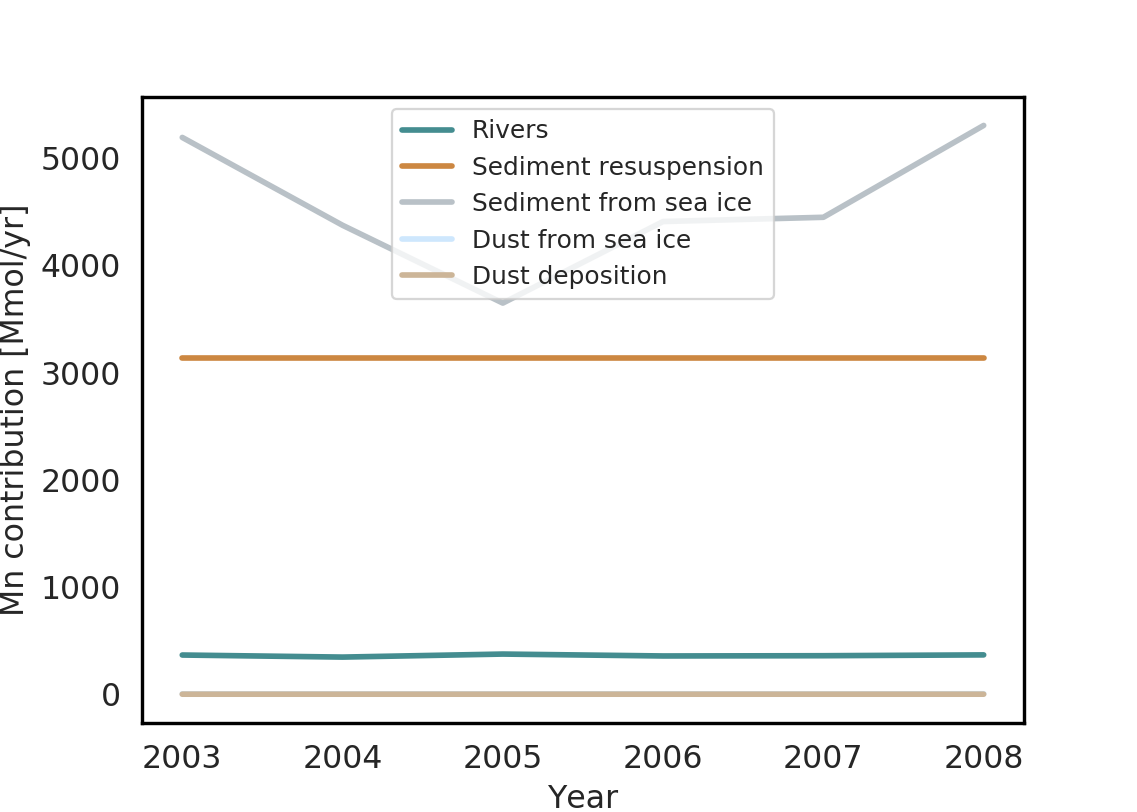

In [33]:
fig = plt.figure(figsize=(7,5))
st  = sns.axes_style("white")

with st:
    rp  = sns.lineplot(years, totals[:,0]*1e-6, linewidth=2.5, color=colors[1], label='Rivers')
    sp  = sns.lineplot(years, totals[:,1]*1e-6, linewidth=2.5, color=colors[3], label='Sediment resuspension')
    sip = sns.lineplot(years, totals[:,2]*1e-6, linewidth=2.5, color=colors[5], label='Sediment from sea ice')
    dip = sns.lineplot(years, totals[:,3]*1e-6, linewidth=2.5, color=colors[4], label='Dust from sea ice')
    dp  = sns.lineplot(years, totals[:,4]*1e-6, linewidth=2.5, color=colors[0], label='Dust deposition')

    rp.set_xlabel('Year', fontsize=14)
    rp.set_ylabel('Mn contribution [Mmol/yr]',fontsize=14)
#     rp.set(ylim=(-6e-9,17e-9))
    rp.tick_params(axis='both', which='major', labelsize=14)
    rp.spines['left'].set_linewidth(1.5);   rp.spines['left'].set_color('black');
    rp.spines['bottom'].set_linewidth(1.5); rp.spines['bottom'].set_color('black');
    rp.spines['right'].set_linewidth(1.5);  rp.spines['right'].set_color('black');
    rp.spines['top'].set_linewidth(1.5);    rp.spines['top'].set_color('black');    
    
# fig.savefig('/ocean/brogalla/GEOTRACES/figures/distr-PML_src.png', bbox_inches='tight',dpi=300)

Separated by region:

<IPython.core.display.Javascript object>


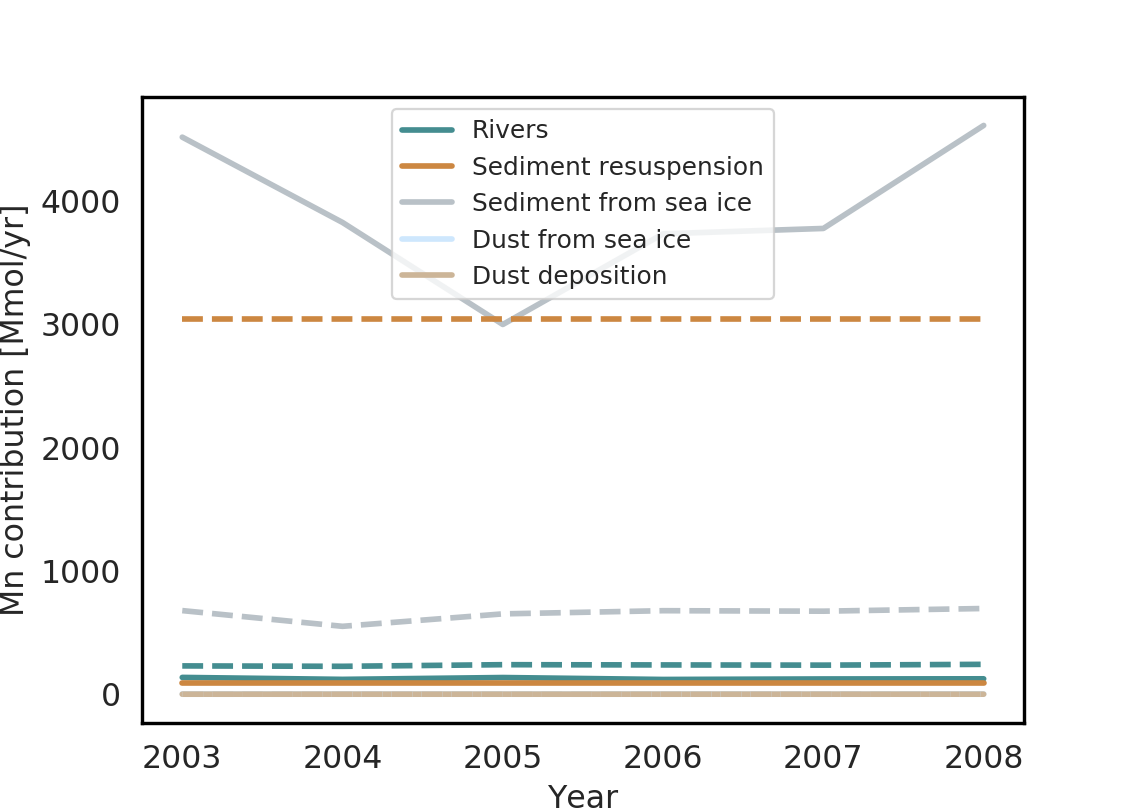

In [34]:
fig = plt.figure(figsize=(7,5))
st  = sns.axes_style("white")

with st:
    rp  = sns.lineplot(years, totals_CB[:,0]*1e-6, linewidth=2.5, color=colors[1], label='Rivers')
    sp  = sns.lineplot(years, totals_CB[:,1]*1e-6, linewidth=2.5, color=colors[3], label='Sediment resuspension')
    sip = sns.lineplot(years, totals_CB[:,2]*1e-6, linewidth=2.5, color=colors[5], label='Sediment from sea ice')
    dip = sns.lineplot(years, totals_CB[:,3]*1e-6, linewidth=2.5, color=colors[4], label='Dust from sea ice')
    dp  = sns.lineplot(years, totals_CB[:,4]*1e-6, linewidth=2.5, color=colors[0], label='Dust deposition')

    rp2  = sns.lineplot(years, totals_CAA[:,0]*1e-6, linewidth=2.5, color=colors[1])
    sp2  = sns.lineplot(years, totals_CAA[:,1]*1e-6, linewidth=2.5, color=colors[3])
    sip2 = sns.lineplot(years, totals_CAA[:,2]*1e-6, linewidth=2.5, color=colors[5])
    dip2 = sns.lineplot(years, totals_CAA[:,3]*1e-6, linewidth=2.5, color=colors[4])
    dp2  = sns.lineplot(years, totals_CAA[:,4]*1e-6, linewidth=2.5, color=colors[0])

    rp.lines[5].set_linestyle("--")
    rp.lines[6].set_linestyle("--")
    rp.lines[7].set_linestyle("--")
    rp.lines[8].set_linestyle("--")
    rp.lines[9].set_linestyle("--")
    
    rp.set_xlabel('Year', fontsize=14)
    rp.set_ylabel('Mn contribution [Mmol/yr]',fontsize=14)
#     rp.set(ylim=(-6e-9,17e-9))
    rp.tick_params(axis='both', which='major', labelsize=14)
    rp.spines['left'].set_linewidth(1.5);   rp.spines['left'].set_color('black');
    rp.spines['bottom'].set_linewidth(1.5); rp.spines['bottom'].set_color('black');
    rp.spines['right'].set_linewidth(1.5);  rp.spines['right'].set_color('black');
    rp.spines['top'].set_linewidth(1.5);    rp.spines['top'].set_color('black');    
    
# fig.savefig('/ocean/brogalla/GEOTRACES/figures/distr-PML_src.png', bbox_inches='tight',dpi=300)